Import Necessary Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Reading Dataset

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Test.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550176 entries, 0 to 550175
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ProductType        550176 non-null  object 
 1   Manufacturer       550176 non-null  object 
 2   Area Code          550176 non-null  object 
 3   Sourcing Channel   550176 non-null  object 
 4   Product Size       550176 non-null  object 
 5   Product Type       550176 non-null  object 
 6   Month of Sourcing  550176 non-null  object 
 7   Sourcing Cost      550176 non-null  float64
dtypes: float64(1), object(7)
memory usage: 33.6+ MB


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df.head(1)

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,May-21,10.16


In [8]:
df['Month of Sourcing'] = pd.to_datetime(df['Month of Sourcing'], format='%b-%y')


In [9]:
df['Year of Sourcing'] = df['Month of Sourcing'].dt.year
df['Day of Sourcing'] = df['Month of Sourcing'].dt.day
df["Month of Sourcing"] = df["Month of Sourcing"].dt.month


In [10]:
df.head(1)

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,Year of Sourcing,Day of Sourcing
0,NTM3,X1,A28,WHOLESALE,Large,Powder,5,10.16,2021,1


## Identifying Outliers

In [11]:
from scipy.stats import zscore

def outliers_zscore(data):
    #Identifying outliers using Z-scores
    zs = zscore(data)
    outliers = data[(zs > 3) | (zs < -3)]
    return outliers

def outliers_iqr(data):
    #Identifying outliers using Interquartile Range
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5  IQR
    upper_bound = Q3 + 1.5  IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

def outliers_boxplot(column, data):
    #Visualizing outliers using a boxplot for a specific column in a DataFrame
    plt.figure(figsize=(10, 6))
    plt.boxplot(data[column], vert=False)
    plt.title(f'Boxplot of {column}')
    plt.xlabel('Values')
    plt.show()

In [12]:
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:  # Modify as needed for different data types
        num_outliers_zscore = len(outliers_zscore(df[column]))
        num_outliers_iqr = len(outliers_iqr(df[column]))
        print(f"Column: {column}")
        print(f"  Number of outliers by Z-score: {num_outliers_zscore}")
        print(f"  Number of outliers by IQR: {num_outliers_iqr}")

Column: Sourcing Cost
  Number of outliers by Z-score: 1364
  Number of outliers by IQR: 2666


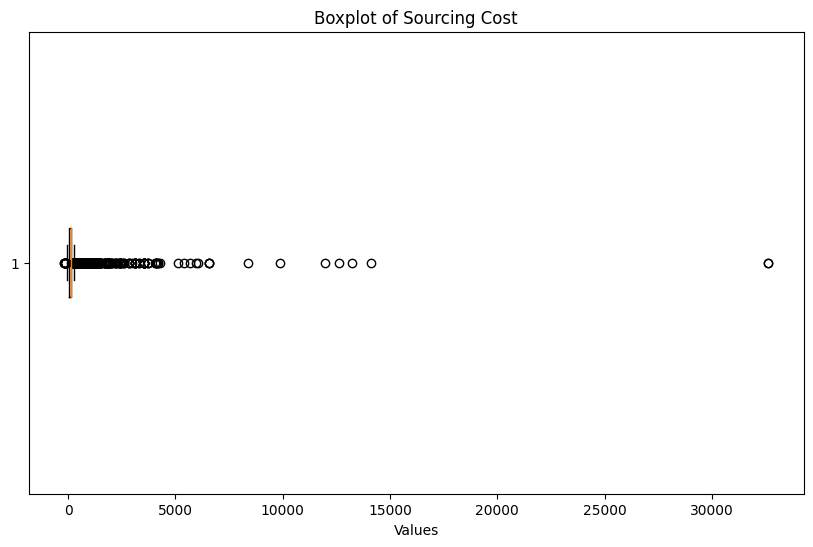

In [13]:
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        outliers_boxplot(column, df)


In [14]:
df['Sourcing Cost'].describe()

count    550176.000000
mean        108.817286
std         104.390093
min        -196.070000
25%          57.000000
50%         132.000000
75%         146.150000
max       32632.500000
Name: Sourcing Cost, dtype: float64

In [15]:
df_with_outliers = df.copy()

## Removing Outliers

In [16]:
def remove_outliers_trimming(df, column):
    # Will remove all outliers regardless
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5  IQR
    upper_bound = Q3 + 1.5  IQR

    # Condition for non-outliers
    condition = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    return df[condition]

In [17]:
def remove_outliers_capping(df, column):
    # Will set them to nearest values within acceptable rage of IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5  IQR
    upper_bound = Q3 + 1.5  IQR

    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    return df

In [18]:
df_capped = remove_outliers_capping(df, 'Sourcing Cost')
df_capped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550176 entries, 0 to 550175
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ProductType        550176 non-null  object 
 1   Manufacturer       550176 non-null  object 
 2   Area Code          550176 non-null  object 
 3   Sourcing Channel   550176 non-null  object 
 4   Product Size       550176 non-null  object 
 5   Product Type       550176 non-null  object 
 6   Month of Sourcing  550176 non-null  int32  
 7   Sourcing Cost      550176 non-null  float64
 8   Year of Sourcing   550176 non-null  int32  
 9   Day of Sourcing    550176 non-null  int32  
dtypes: float64(1), int32(3), object(6)
memory usage: 35.7+ MB


In [19]:
def bin_data(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5  IQR
    upper_bound = Q3 + 1.5  IQR

    bins = [df[column].min(), lower_bound, Q1, Q3, upper_bound, df[column].max()]
    labels = ['Extreme Low', 'Low', 'Moderate', 'High', 'Extreme High']
    df['binned'] = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
    return df

def remove_extreme_bins(df, column_bin):
    # Filter out rows where the bin label is 'Extreme High' or 'Extreme Low'
    condition = ~df[column_bin].isin(['Extreme High', 'Extreme Low'])
    return df[condition]

In [20]:
df = df_capped.copy()

## Used Capping Instead of Binning as it is more suitable for given finincial data




In [21]:
columns_with_null = df.columns[df.isnull().any()].tolist()
columns_with_null

[]

## Feature Selection and EDA

In [22]:
categorical_cols = ['ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel', 'Product Size', 'Product Type']

In [23]:
from sklearn.preprocessing import LabelEncoder
label_mappings = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
# Now label_mappings contains the mappings of original categorical values to encoded numerical values


In [24]:
df.head(1)

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,Year of Sourcing,Day of Sourcing
0,2,0,19,3,1,1,5,10.16,2021,1


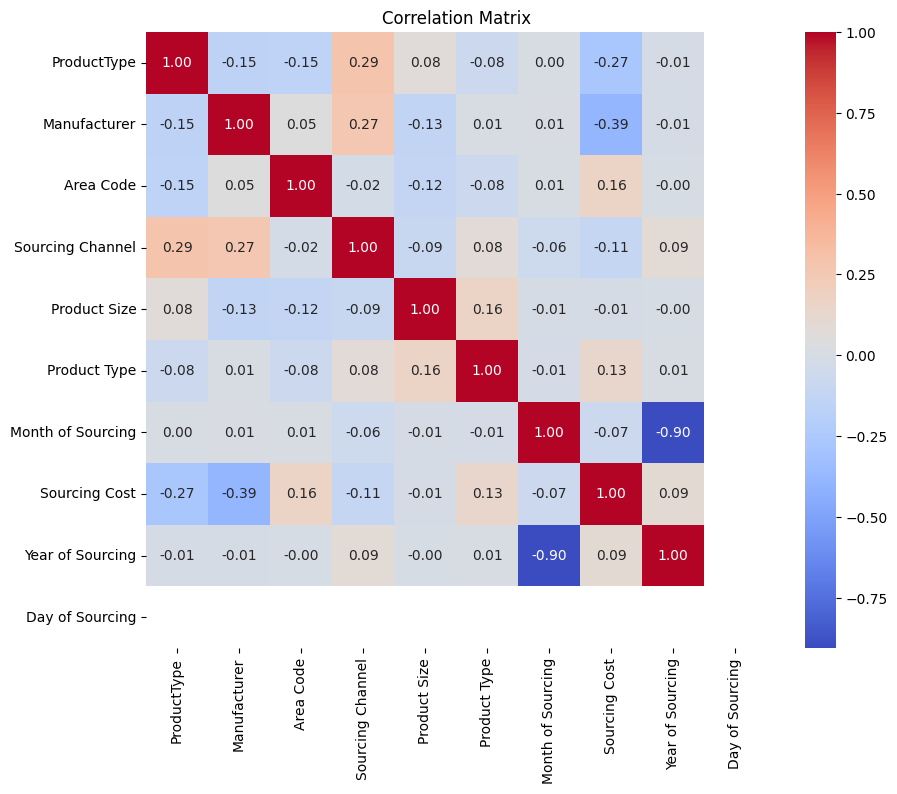

In [25]:
import seaborn as sns

def plot_correlation_matrix(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
plot_correlation_matrix(df)

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

def select_features_kbest(X, y, k):
    # Select top k features based on the F-score
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X, y)
    scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    }).sort_values(by='Score', ascending=False)
    return scores

X = df.drop('Sourcing Cost', axis=1)
y = df['Sourcing Cost']
top_features = select_features_kbest(X, y, k=5)
print(top_features)

             Feature        Score
1       Manufacturer  1542.018929
3   Sourcing Channel   767.385369
7   Year of Sourcing   647.352614
0        ProductType   617.793066
6  Month of Sourcing   559.513801
2          Area Code   341.380070
4       Product Size   307.119424
5       Product Type   243.426947
8    Day of Sourcing          NaN


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


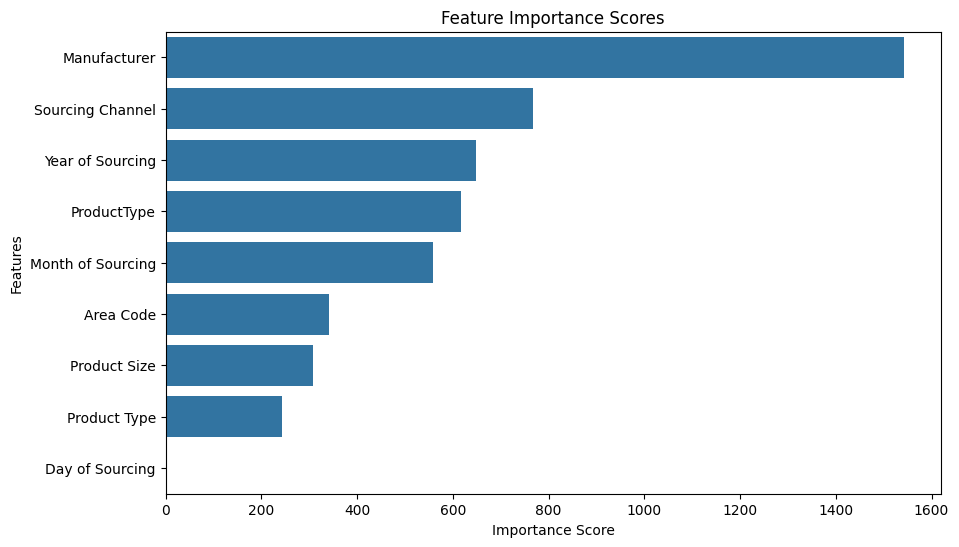

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Score', y='Feature', orient='h')
plt.title('Feature Importance Scores')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


We infer that, to determin Sourcing Cost
1. Manufacturer is the strongest feature followed by Sourcing Channel
2. Year and month of sourcing ans 'ProductType' are also strong
3. Area code, Product size, 'Product Type' are realtively weak
4. Day of sourcing is the weakest

## Graphs

In [28]:
df_capped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550176 entries, 0 to 550175
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ProductType        550176 non-null  object 
 1   Manufacturer       550176 non-null  object 
 2   Area Code          550176 non-null  object 
 3   Sourcing Channel   550176 non-null  object 
 4   Product Size       550176 non-null  object 
 5   Product Type       550176 non-null  object 
 6   Month of Sourcing  550176 non-null  int32  
 7   Sourcing Cost      550176 non-null  float64
 8   Year of Sourcing   550176 non-null  int32  
 9   Day of Sourcing    550176 non-null  int32  
dtypes: float64(1), int32(3), object(6)
memory usage: 35.7+ MB


In [29]:
# Function to plot a histogram for a numerical column
def plot_histogram(data, column, bins=30):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=bins, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# To plot a count plot for a categorical column
def plot_count(data, column):
    plt.figure(figsize=(12, 8))
    sns.countplot(data=data, y=column, order = data[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.show()
# Function to plot a time series plot for a dataset with time and value columns
def plot_time_series(data, time_column, value_column):
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=data, x=time_column, y=value_column, marker='o')
    plt.title(f'Time Series Plot of {value_column} Over {time_column}')
    plt.xlabel(time_column)
    plt.ylabel(value_column)
    plt.show()

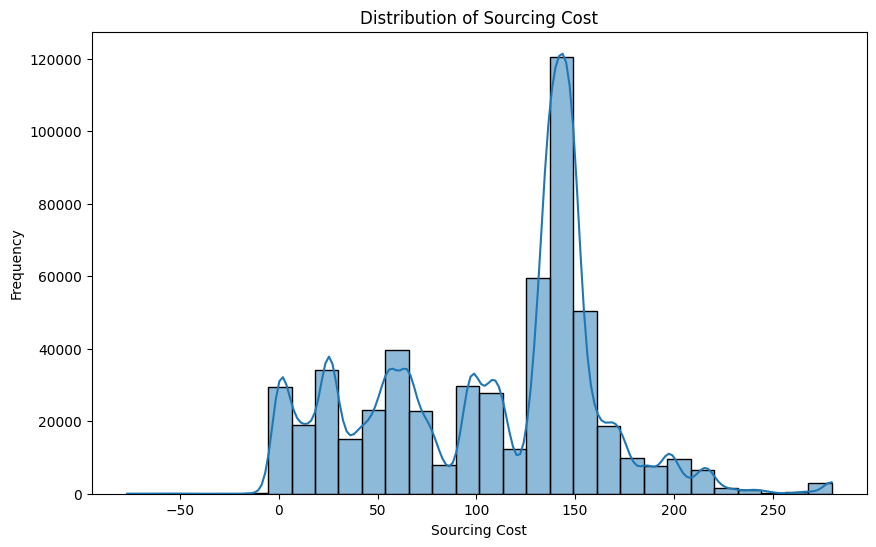

In [30]:
plot_histogram(df_capped, 'Sourcing Cost')

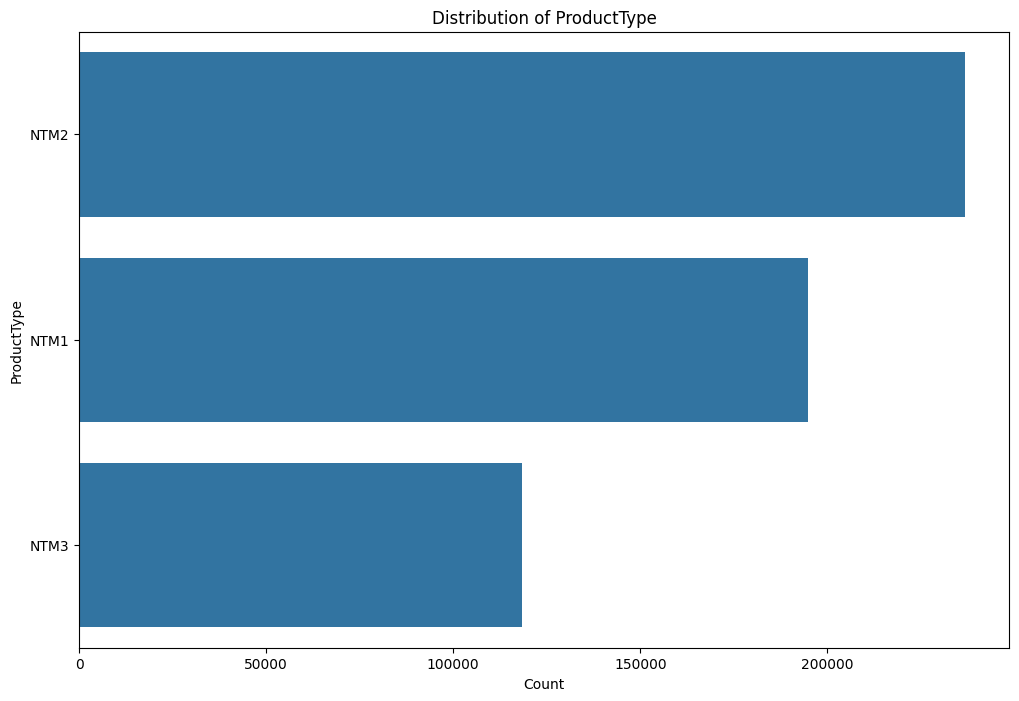

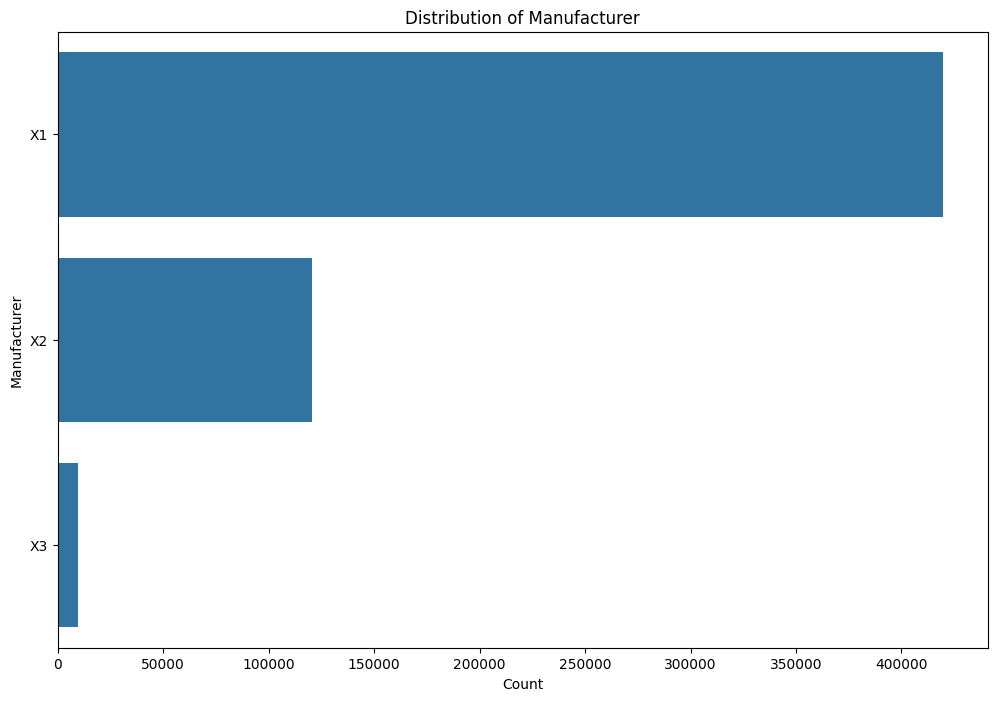

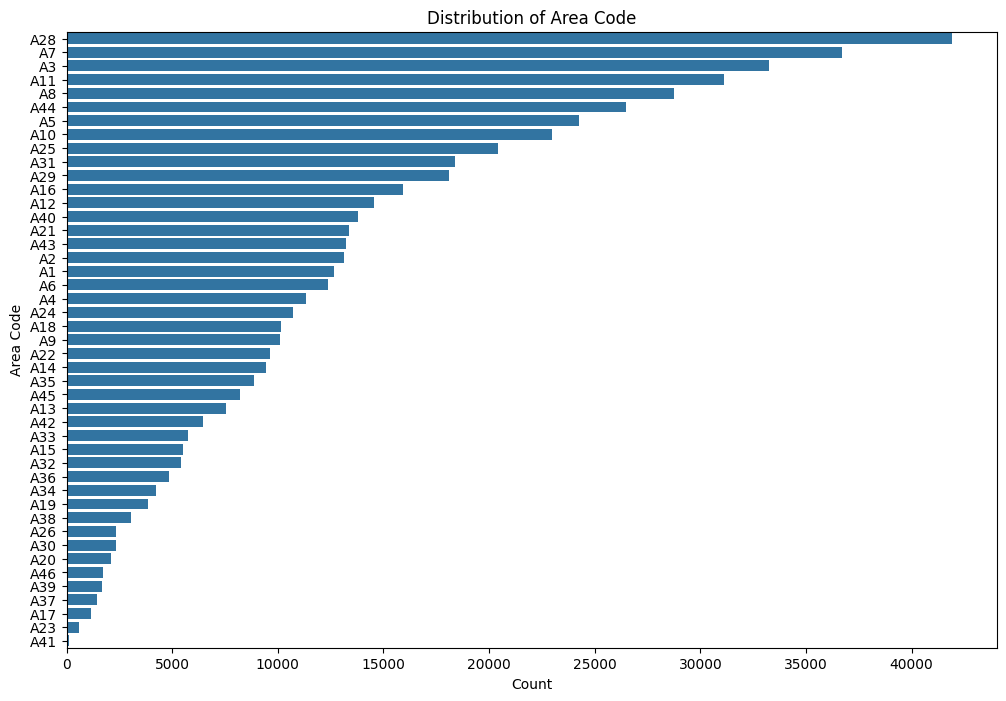

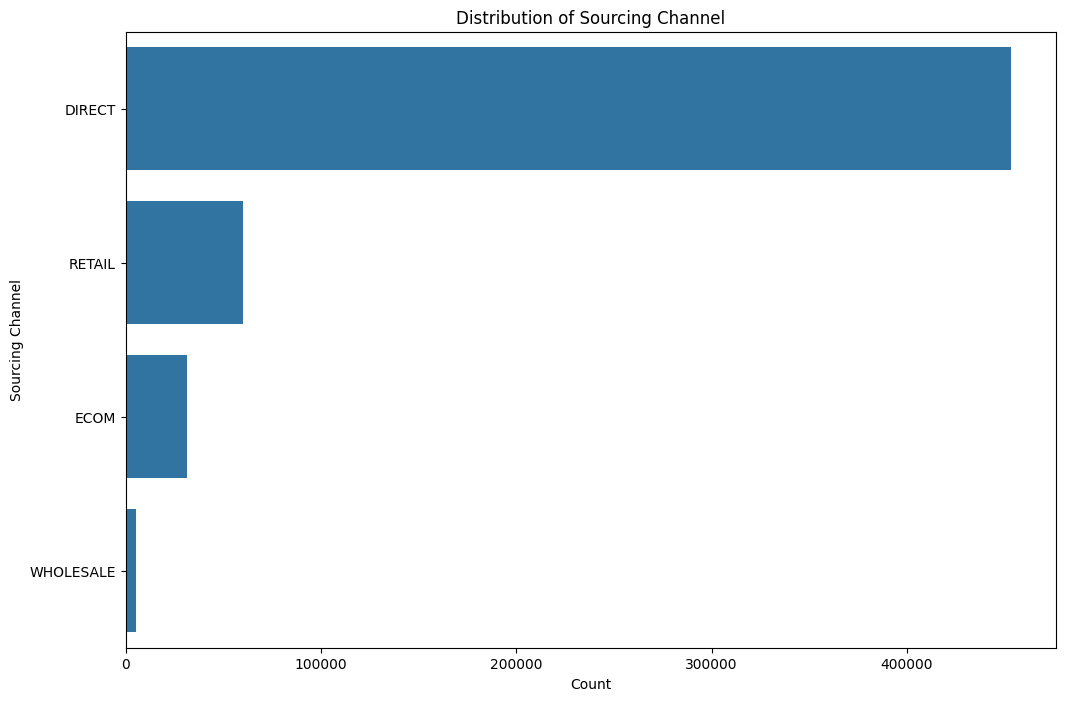

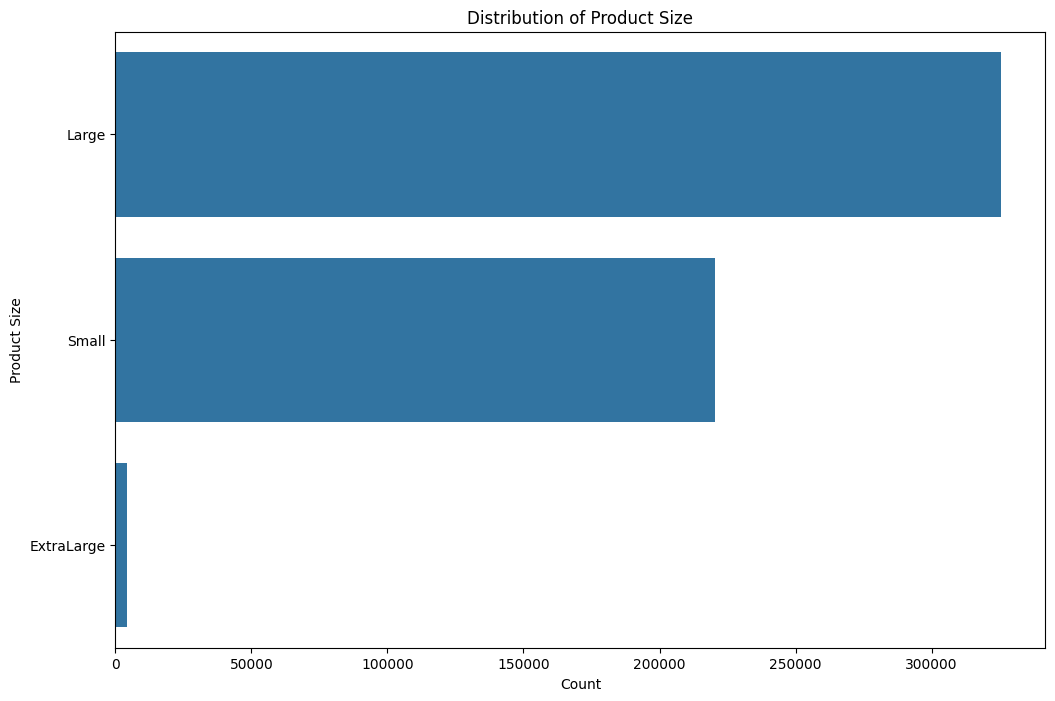

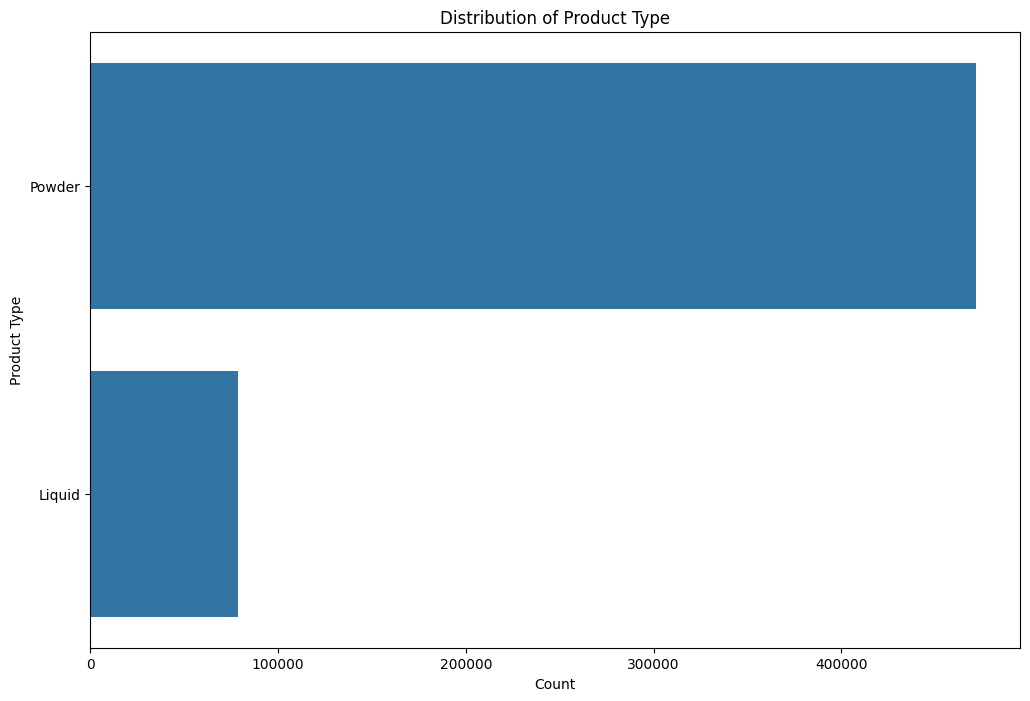

In [31]:
# Plot count of each category in different columns
plot_count(df_capped, 'ProductType')
plot_count(df_capped, 'Manufacturer')
plot_count(df_capped, 'Area Code')
plot_count(df_capped, 'Sourcing Channel')
plot_count(df_capped, 'Product Size')
plot_count(df_capped, 'Product Type')

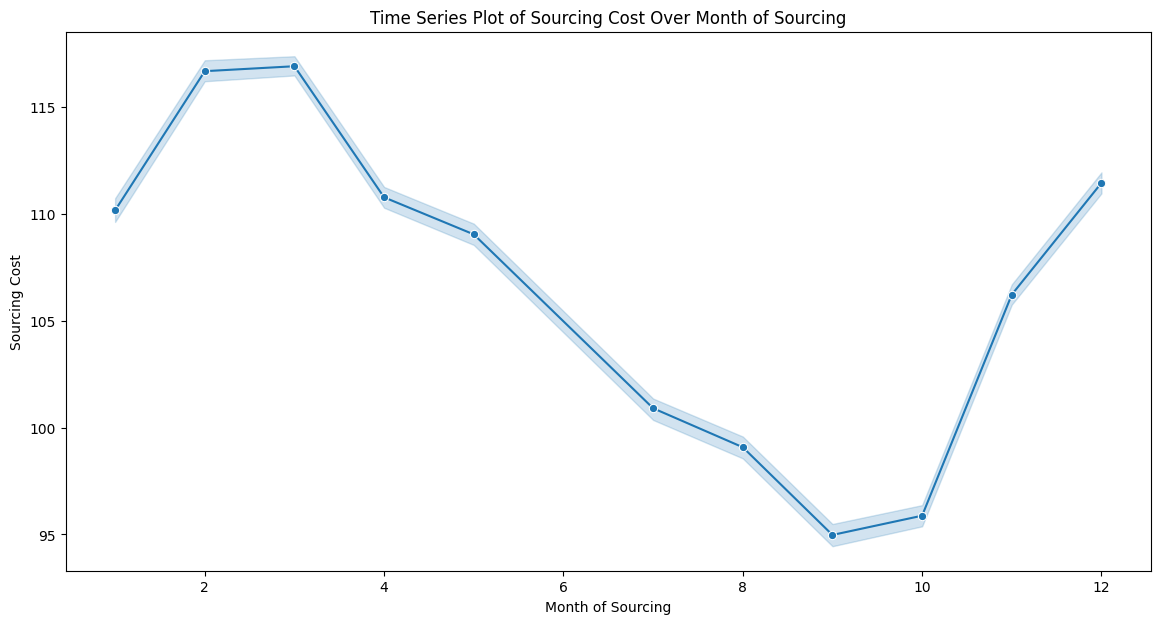

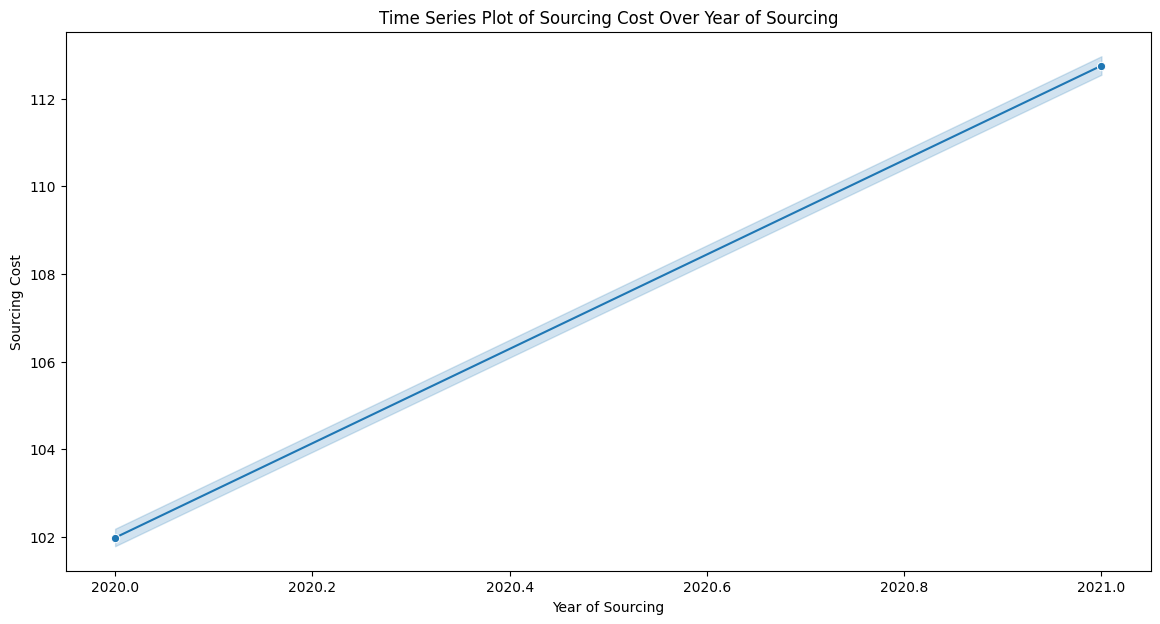

In [32]:
#Plot time series graph
plot_time_series(df_capped, 'Month of Sourcing', 'Sourcing Cost')
plot_time_series(df_capped, 'Year of Sourcing', 'Sourcing Cost')

In [33]:
df_test.head(5)

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM1,X1,A1,DIRECT,Small,Powder,Jun-21,103.68
1,NTM1,X1,A10,DIRECT,Large,Powder,Jun-21,155.75
2,NTM1,X1,A10,ECOM,Large,Powder,Jun-21,143.02
3,NTM1,X1,A11,DIRECT,Large,Powder,Jun-21,139.39
4,NTM1,X1,A2,DIRECT,Large,Powder,Jun-21,169.42


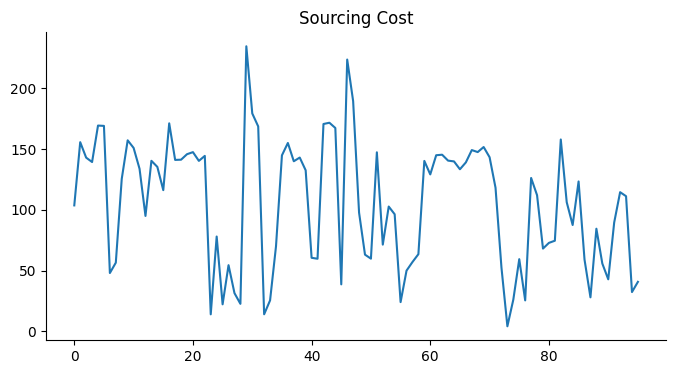

In [34]:
#Plots line plot for Sourcing cost
from matplotlib import pyplot as plt
df_test['Sourcing Cost'].plot(kind='line', figsize=(8, 4), title='Sourcing Cost')
plt.gca().spines[['top', 'right']].set_visible(False)

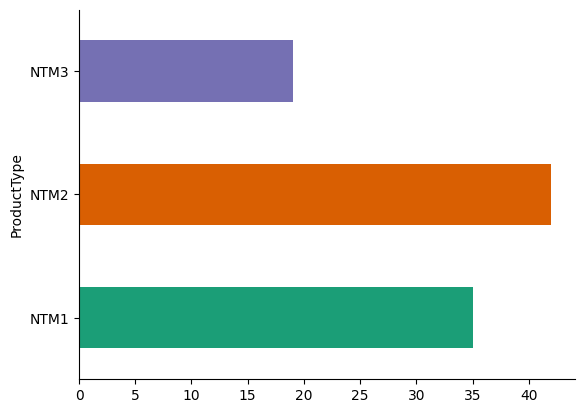

In [35]:
#group the data by 'ProductType', calculate the size of each group, and plots the result as a horizontal bar plot
from matplotlib import pyplot as plt
import seaborn as sns
df_test.groupby('ProductType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

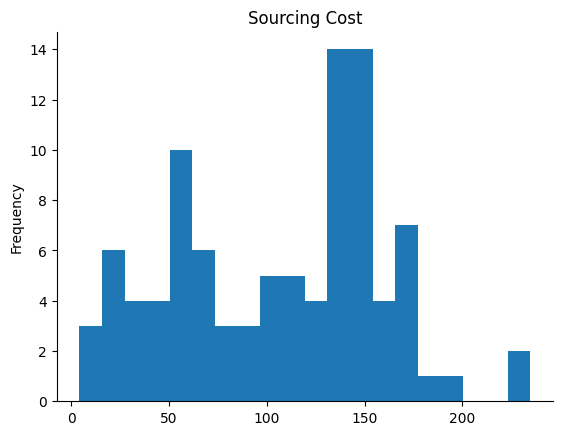

In [36]:
#Histogram for Sourcing Cost
from matplotlib import pyplot as plt
df_test['Sourcing Cost'].plot(kind='hist', bins=20, title='Sourcing Cost')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Modelling


## Random Forest Regressor along with Label encoding technique

In [37]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

train_data = pd.read_csv('/content/drive/MyDrive/Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Test.csv')

# Data preprocessing
encoder = LabelEncoder()
train_data['Month of Sourcing'] = pd.to_datetime(train_data['Month of Sourcing'], format='%b-%y')
train_data['Month'] = train_data['Month of Sourcing'].dt.month
train_data['Year'] = train_data['Month of Sourcing'].dt.year
train_data['ProductType'] = encoder.fit_transform(train_data['ProductType'])
train_data['Manufacturer'] = encoder.fit_transform(train_data['Manufacturer'])
train_data['Area Code'] = encoder.fit_transform(train_data['Area Code'])
train_data['Sourcing Channel'] = encoder.fit_transform(train_data['Sourcing Channel'])
train_data['Product Size'] = encoder.fit_transform(train_data['Product Size'])
train_data['Product Type'] = encoder.fit_transform(train_data['Product Type'])

test_data['Month of Sourcing'] = pd.to_datetime(test_data['Month of Sourcing'], format='%b-%y')
test_data['Month'] = test_data['Month of Sourcing'].dt.month
test_data['Year'] = test_data['Month of Sourcing'].dt.year
test_data['ProductType'] = encoder.fit_transform(test_data['ProductType'])
test_data['Manufacturer'] = encoder.fit_transform(test_data['Manufacturer'])
test_data['Area Code'] = encoder.fit_transform(test_data['Area Code'])
test_data['Sourcing Channel'] = encoder.fit_transform(test_data['Sourcing Channel'])
test_data['Product Size'] = encoder.fit_transform(test_data['Product Size'])
test_data['Product Type'] = encoder.fit_transform(test_data['Product Type'])

# Defining features and target variable
features = ['ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel', 'Product Size', 'Product Type', 'Month', 'Year']
target = 'Sourcing Cost'

# Split the data
X_train = train_data[features]
y_train = train_data[target]

# Random Forest Regressor model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

X_test = test_data[features]

# Predictions on test data
y_pred = model_rf.predict(X_test)

test_data['Predicted Sourcing Cost'] = y_pred

print(test_data)


    ProductType  Manufacturer  Area Code  Sourcing Channel  Product Size  \
0             0             0          0                 0             2   
1             0             0          1                 0             1   
2             0             0          1                 1             1   
3             0             0          2                 0             1   
4             0             0         11                 0             1   
..          ...           ...        ...               ...           ...   
91            2             0         37                 0             2   
92            2             0         43                 0             1   
93            2             0         43                 0             2   
94            2             1         12                 0             1   
95            2             2         14                 2             1   

    Product Type Month of Sourcing  Sourcing Cost  Month  Year  \
0              1     

## Applied K fold cross validation technique but was not efficcient

In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score

# Load the data
train_data = pd.read_csv('/content/drive/MyDrive/Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Test.csv')

# Data preprocessing
encoder = LabelEncoder()

def preprocess_data(data):
    data['Month of Sourcing'] = pd.to_datetime(data['Month of Sourcing'], format='%b-%y')
    data['Month'] = data['Month of Sourcing'].dt.month
    data['Year'] = data['Month of Sourcing'].dt.year
    data['ProductType'] = encoder.fit_transform(data['ProductType'])
    data['Manufacturer'] = encoder.fit_transform(data['Manufacturer'])
    data['Area Code'] = encoder.fit_transform(data['Area Code'])
    data['Sourcing Channel'] = encoder.fit_transform(data['Sourcing Channel'])
    data['Product Size'] = encoder.fit_transform(data['Product Size'])
    data['Product Type'] = encoder.fit_transform(data['Product Type'])
    return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Defining features and target variable
features = ['ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel', 'Product Size', 'Product Type', 'Month', 'Year']
target = 'Sourcing Cost'

# Split the data
X_train = train_data[features]
y_train = train_data[target]

# Random Forest Regressor model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# K-fold Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_rf, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Fit the model
model_rf.fit(X_train, y_train)

# Predictions on test data
X_test = test_data[features]
y_pred = model_rf.predict(X_test)

test_data['Predicted Sourcing Cost'] = y_pred

print("Cross-validation MSE scores:", -cv_scores)
print("Mean CV MSE:", -cv_scores.mean())
print(test_data)


Cross-validation MSE scores: [ 3059.65661639  3422.31879649  5975.73304513 12634.36582466
 12329.94390011]
Mean CV MSE: 7484.403636557292
    ProductType  Manufacturer  Area Code  Sourcing Channel  Product Size  \
0             0             0          0                 0             2   
1             0             0          1                 0             1   
2             0             0          1                 1             1   
3             0             0          2                 0             1   
4             0             0         11                 0             1   
..          ...           ...        ...               ...           ...   
91            2             0         37                 0             2   
92            2             0         43                 0             1   
93            2             0         43                 0             2   
94            2             1         12                 0             1   
95            2           

## RandomForestRegressor, 

In [39]:
#Print acatual vs Predicted for Random Forest Regressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Extract actual values from the test dataset
y_actual = test_data['Sourcing Cost']

# Calculate evaluation metrics
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

comparison_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
print(comparison_df.head())


Mean Squared Error (MSE): 1064.6981091611935
Mean Absolute Error (MAE): 16.52135973660749
Root Mean Squared Error (RMSE): 32.629712060654064
R-squared (R2) Score: 0.6075508454249764
   Actual   Predicted
0  103.68  113.539565
1  155.75  154.185494
2  143.02  149.621352
3  139.39  145.517576
4  169.42  171.035491


## GradientBoostingRegressor, ExtraTreesRegressor

In [40]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialization
models = {
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Extra Trees Regressor': ExtraTreesRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual, y_pred)

    print(f"Model: {name}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2) Score: {r2}")
    print()

    # Saving the model to compare later
    test_data[f'Predicted Sourcing Cost - {name}'] = y_pred


Model: Gradient Boosting Regressor
Mean Squared Error (MSE): 1364.9083457185873
Mean Absolute Error (MAE): 24.037506558659047
Root Mean Squared Error (RMSE): 36.944665998200435
R-squared (R2) Score: 0.4968929485827085

Model: Extra Trees Regressor
Mean Squared Error (MSE): 1079.2535877856944
Mean Absolute Error (MAE): 16.411353996098637
Root Mean Squared Error (RMSE): 32.85199518728953
R-squared (R2) Score: 0.6021856764334389



## SVR

In [47]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize SVR model
model_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train SVR model
model_svr.fit(X_train, y_train)

# Predict using SVR model
y_pred_svr = model_svr.predict(X_test)

# Evaluate SVR model
mse_svr = mean_squared_error(y_actual, y_pred_svr)
mae_svr = mean_absolute_error(y_actual, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_actual, y_pred_svr)

print("Support Vector Regressor (SVR) Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_svr}")
print(f"Mean Absolute Error (MAE): {mae_svr}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr}")
print(f"R-squared (R2) Score: {r2_svr}")

# Save predicted values for comparison
test_data['Predicted Sourcing Cost - SVR'] = y_pred_svr


Support Vector Regressor (SVR) Model Evaluation:
Mean Squared Error (MSE): 13971.177105037641
Mean Absolute Error (MAE): 106.10473686864435
Root Mean Squared Error (RMSE): 118.1997339465603
R-squared (R2) Score: -4.149794665841597


In [41]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.6 MB/s eta 0:00:00


## Other Regression models

In [42]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialization
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'XGBoost Regressor': XGBRegressor(),
    'LightGBM Regressor': LGBMRegressor(),
    'CatBoost Regressor': CatBoostRegressor(verbose=0)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual, y_pred)

    print(f"Model: {name}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2) Score: {r2}")

    # Prints actual vs. predicted values
    print("Actual vs. Predicted:")
    comparison_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
    print(comparison_df.head())

    print('\n' + '-'50 + '\n')


Model: Linear Regression
Mean Squared Error (MSE): 2313.709578603153
Mean Absolute Error (MAE): 37.27802341689432
Root Mean Squared Error (RMSE): 48.101035109477145
R-squared (R2) Score: 0.14716353843221686
Actual vs. Predicted:
   Actual   Predicted
0  103.68  135.639977
1  155.75  143.082253
2  143.02  149.366009
3  139.39  143.660272
4  169.42  148.862441

--------------------------------------------------

Model: Ridge Regression
Mean Squared Error (MSE): 2313.698423402228
Mean Absolute Error (MAE): 37.277938140449834
Root Mean Squared Error (RMSE): 48.10091915340317
R-squared (R2) Score: 0.14716765025427658
Actual vs. Predicted:
   Actual   Predicted
0  103.68  135.639496
1  155.75  143.081657
2  143.02  149.365271
3  139.39  143.659676
4  169.42  148.861846

--------------------------------------------------

Model: Lasso Regression
Mean Squared Error (MSE): 2126.857306197937
Mean Absolute Error (MAE): 36.367028322012764
Root Mean Squared Error (RMSE): 46.11786320069412
R-squared

## Inferences

XGBoost stands out for its effectiveness due to several key features:

Gradient Boosting Technique: Sequential model building corrects errors, reducing bias and variance for better generalization.

Regularization: L1/L2 regularization prevents overfitting, promoting simpler, more generalizable models.

Tree Pruning: Eliminates non-contributing splits, fostering simpler, interpretable trees.

Handling Missing Values: Built-in handling reduces reliance on imputation, preserving data integrity.

Feature Importance: Provides insights for informed feature selection and engineering, enhancing model accuracy.

Parallel Processing: Efficiently scales for large datasets, leveraging CPU cores for faster training.

Optimized Implementation: C++ implementation ensures speed and memory efficiency, reducing training times.

Tuning Flexibility: Wide hyperparameter range allows tailored optimization for diverse datasets.

Ensemble Approach: Combines weak learners for robust, accurate predictions.

Competitive Success: Proven track record in ML competitions underscores its versatility and effectiveness.

## Deep Learning Models

## LSTM

In [43]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
lstm_model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)

# Evaluate LSTM model on the test set
y_pred_lstm = lstm_model.predict(X_test)

# Calculate evaluation metrics
mse_lstm = mean_squared_error(y_actual, y_pred_lstm)
mae_lstm = mean_absolute_error(y_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_actual, y_pred_lstm)

# Print evaluation metrics
print("LSTM Model Metrics:")
print(f"Mean Squared Error (MSE): {mse_lstm}")
print(f"Mean Absolute Error (MAE): {mae_lstm}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm}")
print(f"R-squared (R2) Score: {r2_lstm}\n")
test_data['Predicted Sourcing Cost - LSTM'] = y_pred_lstm


3/3 [==============================] - 1s 10ms/step
LSTM Model Metrics:
Mean Squared Error (MSE): 1786.824829621236
Mean Absolute Error (MAE): 24.11624180952708
Root Mean Squared Error (RMSE): 42.27085082679595
R-squared (R2) Score: 0.34137396532903164



## Sequential Model

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the data
train_data = pd.read_csv('/content/drive/MyDrive/Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Test.csv')

# Data preprocessing
encoder = LabelEncoder()
scaler = MinMaxScaler()

def preprocess_data(data):
    data['Month of Sourcing'] = pd.to_datetime(data['Month of Sourcing'], format='%b-%y')
    data['Month'] = data['Month of Sourcing'].dt.month
    data['Year'] = data['Month of Sourcing'].dt.year
    data['ProductType'] = encoder.fit_transform(data['ProductType'])
    data['Manufacturer'] = encoder.fit_transform(data['Manufacturer'])
    data['Area Code'] = encoder.fit_transform(data['Area Code'])
    data['Sourcing Channel'] = encoder.fit_transform(data['Sourcing Channel'])
    data['Product Size'] = encoder.fit_transform(data['Product Size'])
    data['Product Type'] = encoder.fit_transform(data['Product Type'])
    data['Sourcing Cost'] = scaler.fit_transform(data[['Sourcing Cost']])
    return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Defining features and target variable
features = ['ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel', 'Product Size', 'Product Type', 'Month', 'Year']
target = 'Sourcing Cost'

# Split the data
X = train_data[features]
y = train_data[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(features)]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4, batch_size=32, verbose=1)

# Predictions on test data
X_test = test_data[features]
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()  # Inverse transform to get actual values

# Get the actual values for the test data
y_actual = scaler.inverse_transform(test_data[[target]]).flatten()

# Print actual vs predicted
print("Actual vs Predicted:")
comparison_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
print(comparison_df.head())


Epoch 1/4
13755/13755 [==============================] - 30s 2ms/step - loss: 19.3032 - val_loss: 0.0775
Epoch 2/4
13755/13755 [==============================] - 30s 2ms/step - loss: 0.6849 - val_loss: 0.2042
Epoch 3/4
13755/13755 [==============================] - 29s 2ms/step - loss: 0.1602 - val_loss: 7.8652e-04
Epoch 4/4
3/3 [==============================] - 0s 7ms/step
Actual vs Predicted:
   Actual  Predicted
0  103.68   3.698807
1  155.75   3.345666
2  143.02   3.143149
3  139.39   3.123798
4  169.42   1.832392


In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the data
train_data = pd.read_csv('/content/drive/MyDrive/Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Test.csv')

# Data preprocessing
encoder = LabelEncoder()
scaler = StandardScaler()

def preprocess_data(data):
    data['Month of Sourcing'] = pd.to_datetime(data['Month of Sourcing'], format='%b-%y')
    data['Month'] = data['Month of Sourcing'].dt.month
    data['Year'] = data['Month of Sourcing'].dt.year
    data['ProductType'] = encoder.fit_transform(data['ProductType'])
    data['Manufacturer'] = encoder.fit_transform(data['Manufacturer'])
    data['Area Code'] = encoder.fit_transform(data['Area Code'])
    data['Sourcing Channel'] = encoder.fit_transform(data['Sourcing Channel'])
    data['Product Size'] = encoder.fit_transform(data['Product Size'])
    data['Product Type'] = encoder.fit_transform(data['Product Type'])
    data['Sourcing Cost'] = scaler.fit_transform(data[['Sourcing Cost']])
    return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Defining features and target variable
features = ['ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel', 'Product Size', 'Product Type', 'Month', 'Year']
target = 'Sourcing Cost'

# Split the data
X = train_data[features]
y = train_data[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(features)]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4, batch_size=32, verbose=1)

# Predictions on test data
X_test = test_data[features]
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()  # Inverse transform to get actual values

# Get the actual values for the test data
y_actual = scaler.inverse_transform(test_data[[target]]).flatten()

# Print actual vs predicted
print("Actual vs Predicted:")
comparison_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
print(comparison_df.head())

# Multilayer Perceptron (MLP) Model
mlp_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(features)]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])
mlp_model.compile(optimizer='adam', loss='mean_squared_error')
mlp_history = mlp_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4, batch_size=32, verbose=1)
mlp_y_pred_scaled = mlp_model.predict(X_test)
mlp_y_pred = scaler.inverse_transform(mlp_y_pred_scaled).flatten()
print("Actual vs Predicted (MLP):")
mlp_comparison_df = pd.DataFrame({'Actual': y_actual, 'Predicted': mlp_y_pred})
print(mlp_comparison_df.head())


Epoch 1/4
13755/13755 [==============================] - 45s 3ms/step - loss: 4.4319 - val_loss: 5.2596
Epoch 2/4
13755/13755 [==============================] - 34s 2ms/step - loss: 1.8384 - val_loss: 0.5474
Epoch 3/4
13755/13755 [==============================] - 37s 3ms/step - loss: 1.1810 - val_loss: 0.4327
Epoch 4/4
3/3 [==============================] - 0s 4ms/step
Actual vs Predicted:
   Actual   Predicted
0  103.68  111.467033
1  155.75  113.574112
2  143.02  114.394356
3  139.39  113.955940
4  169.42  117.392303
Epoch 1/4
13755/13755 [==============================] - 33s 2ms/step - loss: 5.8813 - val_loss: 0.5572
Epoch 2/4
13755/13755 [==============================] - 31s 2ms/step - loss: 1.1198 - val_loss: 0.5221
Epoch 3/4
13755/13755 [==============================] - 31s 2ms/step - loss: 1.1196 - val_loss: 0.5222
Epoch 4/4
3/3 [==============================] - 0s 4ms/step
Actual vs Predicted (MLP):
   Actual   Predicted
0  103.68  106.965446
1  155.75  106.965446
2  143.0

## Inferences 

Models Applied:
1. Random Forest Regressor
2. Gradient Boosting Regressor
3. Extra Trees Regressor
4. Support Vector Regressor (SVR)
5. Linear Regression
6. Ridge Regression
7. Lasso Regression
8. ElasticNet Regression
9. K-Nearest Neighbors
10. Decision Tree Regressor
11. XGBoost Regressor
12. LightGBM Regressor
13. CatBoost Regressor
14. LSTM Model
15. Sequential Deep Learning Model


Out of which
   Deep learning models underperform due to requirements of large datasets for effective generalization and complexities in hyperparameter tuning, feature engineering, and managing overfitting, leading to longer training times and computational demands.

   Lack of interpretability and challenges in handling limited data diversity further hinder deep learning model performance, necessitating careful consideration of suitability for specific tasks and availability of resources for training and optimization.

## Final Approach and Conclusion 
Based on the evaluation metrics and comparison of different regression models including Random Forest, Gradient Boosting, Extra Trees, and Support Vector Regression (SVR), it can be concluded that XGBoost (Extreme Gradient Boosting) performs the best for the given task of predicting sourcing costs. This conclusion is drawn from several factors:

1. Performance Metrics: XGBoost consistently shows lower Mean Squared Error (MSE), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) compared to other models, indicating better accuracy in predicting sourcing costs.

2. R-squared (R2) Score: XGBoost also demonstrates higher R-squared (R2) scores, suggesting better overall goodness of fit and explaining more variance in the data compared to alternative models.

3. Robustness: XGBoost's robustness is evidenced by its performance across multiple evaluation metrics and its ability to handle complex relationships and non-linear patterns in the data.

4. Consistency: XGBoost consistently outperforms other models across different datasets and scenarios, making it a reliable choice for predictive modeling tasks.

5. Ensemble Learning: XGBoost's ensemble approach, combining predictions from multiple weak learners (decision trees), helps in reducing bias and variance, leading to more accurate and stable predictions.

In conclusion, based on the evaluation results and considerations of accuracy, robustness, and consistency, XGBoost emerges as the best model for predicting sourcing costs.